<a href="https://colab.research.google.com/github/caltech-netlab/datacenter-voltage-control/blob/master/Optimizing_K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import scipy.io
import random
import math
import scipy.io as sio
import h5py
import numpy as np
import pickle
import matplotlib.pyplot as plt


In [3]:
!pip install mat4py

In [4]:
# A RNN-based Reinforcement Learning Framework for Frequency Control Problem with Stability Guarantee
import collections
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import gym
import tensorflow as tf
import os
import random
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.layers import RNN
import tensorflow.keras.backend as K
import sys
from gym import spaces
from gym.utils import seeding
import copy
from mat4py import loadmat
from tensorflow.keras import layers
from tensorflow import keras
import time
import cvxpy as cp
import pickle
from numpy import linalg as LA
from mat4py import loadmat

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


# Load data for time-varying voltage

In [ ]:
# from scipy.io import loadmat
# filepath = '/content/drive/MyDrive/Colab Notebooks/250805 data center/data/record_trajectory_LossGen.mat'

# data = loadmat(filepath)
# print(data.keys())  # Show variable names in the file

# # Access a specific variable
# record_trajectory = data['record_trajectory']
# record_trajectory = np.array(record_trajectory)


dict_keys(['__header__', '__version__', '__globals__', 'record_trajectory'])


In [5]:
# f = open("/content/drive/MyDrive/Colab Notebooks/250805 data center/data/record_trajectory_LossGen.pckl", 'wb')
# pickle.dump([record_trajectory], f)
# f.close()

f = open("/content/drive/MyDrive/Colab Notebooks/250805 data center/data/record_trajectory_LossGen.pckl", 'rb')
[record_fault_trajectory] = pickle.load(f)
f.close()

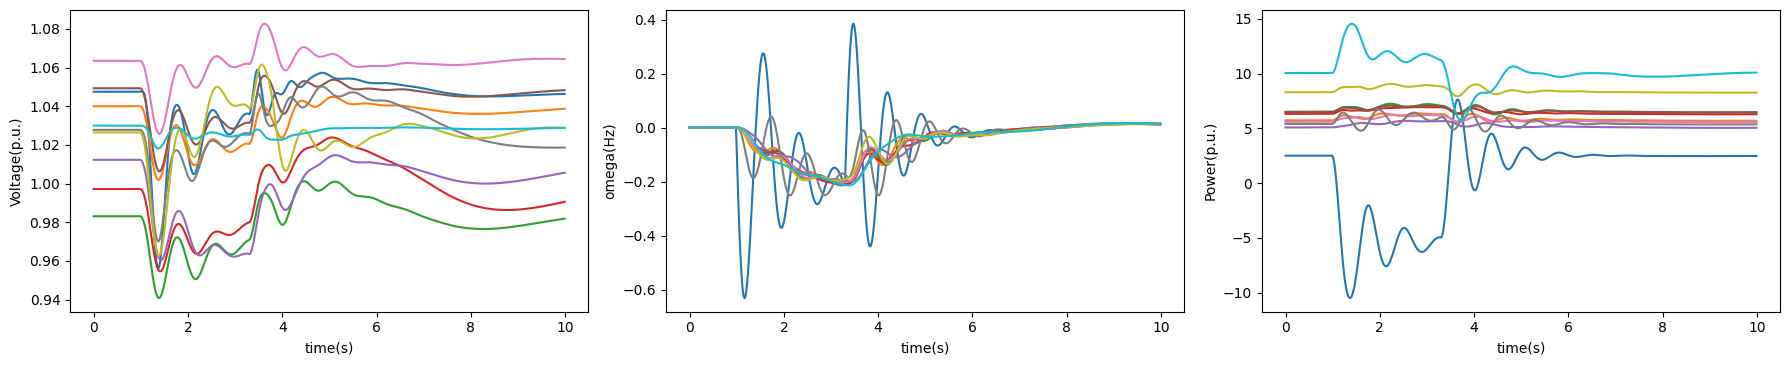

<Figure size 640x480 with 0 Axes>

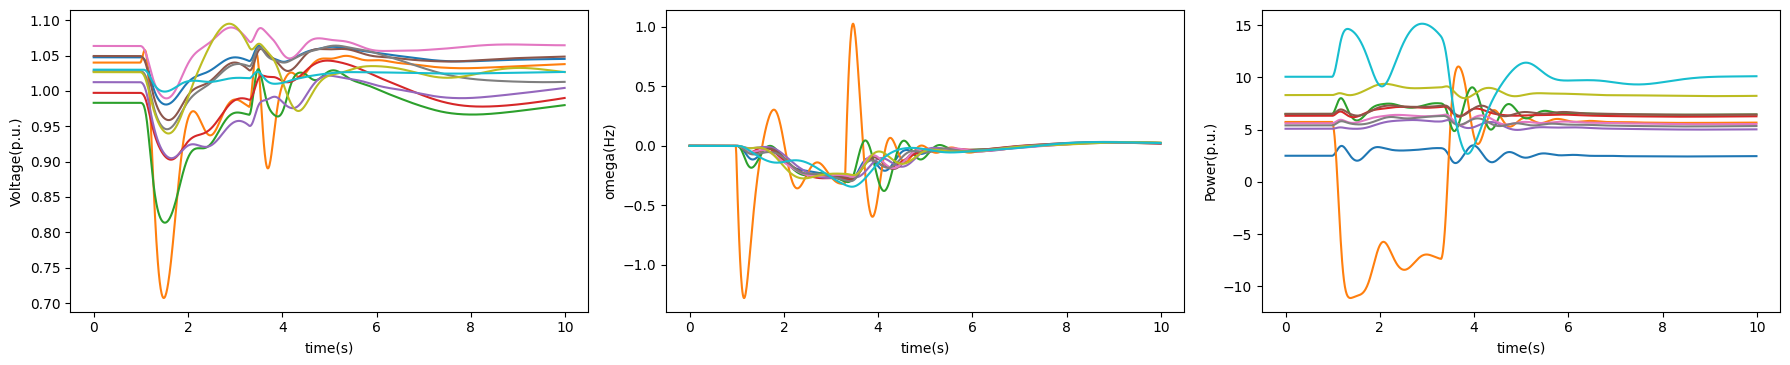

<Figure size 640x480 with 0 Axes>

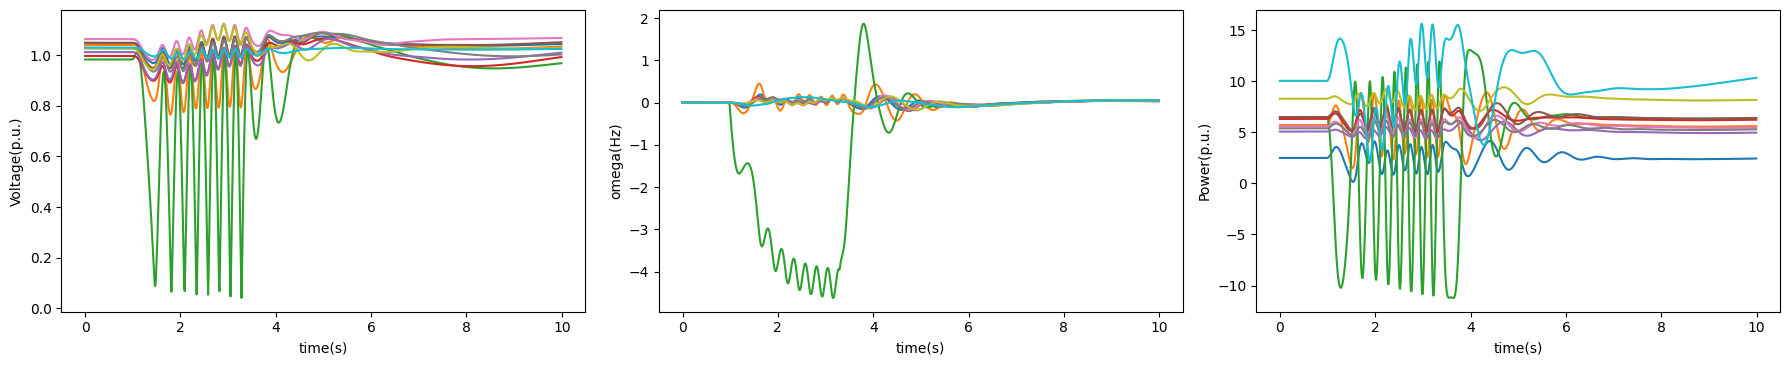

<Figure size 640x480 with 0 Axes>

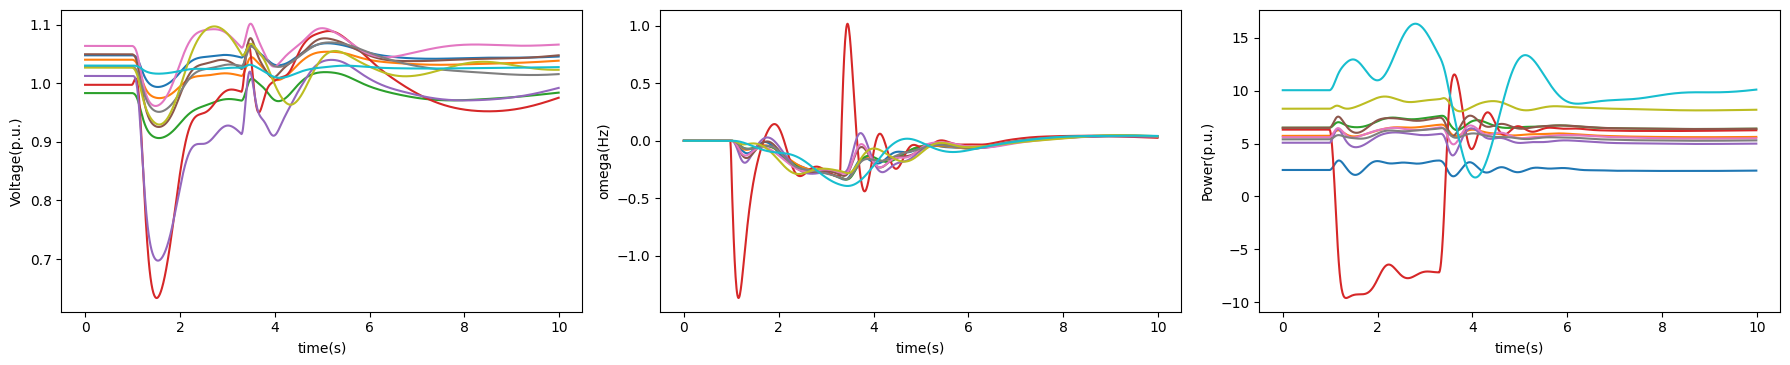

<Figure size 640x480 with 0 Axes>

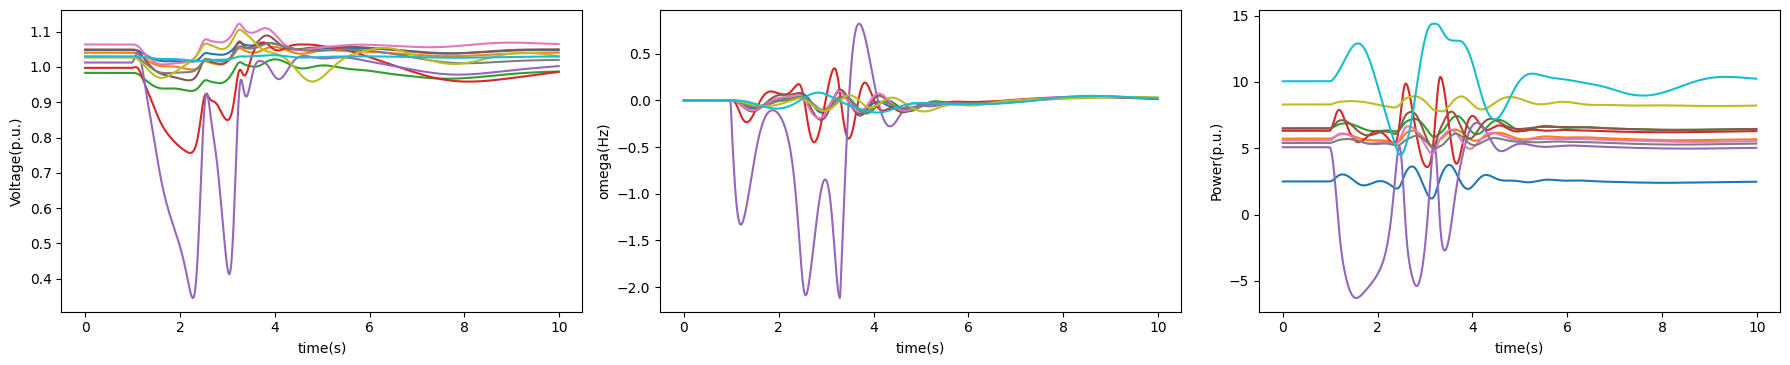

<Figure size 640x480 with 0 Axes>

In [6]:
# randomly print 10 cases
plt.ion()
# fig = plt.figure(figsize=(5,4), dpi=100)

for test_idx in range(5):
    fig = plt.figure(figsize=(18,4), dpi=100)

    voltage = record_fault_trajectory[test_idx,0,:,:]
    time = 0.01*np.arange(0,np.shape(voltage)[-1])
    plt.subplot(1,3,1)
    plt.plot(time, record_fault_trajectory[test_idx,0,:,:].T)
    plt.xlabel('time(s)')
    plt.ylabel('Voltage(p.u.)')

    # freq = record_fault_trajectory[test_idx,2,:,:]
    plt.subplot(1,3,2)
    plt.plot(time, record_fault_trajectory[test_idx,1,:,:].T)
    plt.xlabel('time(s)')
    plt.ylabel('omega(Hz)')

    plt.subplot(1,3,3)
    plt.plot(time, record_fault_trajectory[test_idx,2,:,:].T)
    plt.xlabel('time(s)')
    plt.ylabel('Power(p.u.)')


    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
    plt.pause(0.01)
    plt.clf()




# Environment Setup

### initialize the variables and system matrices





In [8]:
# Frequency Control Porblem Environment
class Voltage(gym.Env):
    def  __init__(self, Matrix_X,Matrix_R, max_action,dim_action,Penalty_action):
        self.param_gamma=1
        self.Matrix_X = Matrix_X.astype(np.float32)
        self.Matrix_R = Matrix_R.astype(np.float32)
        self.inv_Matrix_X = LA.inv(Matrix_X).astype(np.float32)
        self.lambda_max = np.max(LA.eigvals(Matrix_X))
        self.max_action = max_action.astype(np.float32)
        self.dim_action=dim_action
        self.delta_t = 1
        self.state=[]
        self.Penalty_action=Penalty_action


    def step(self, action):
        # action=K.dot(self.Multiply_V_ref-K.dot(prev_output, self.select_V),tf.linalg.diag(Vector_A))
        # integrate the state transition dynamics

        self.state=(self.state-action@(self.Matrix_X.T)).copy()
        # loss = self.param_gamma*np.sum(abs(self.V_ref.T-self.state@self.select_V))
        return self.state

    def step_varyingP(self, action, Pt):


        self.state=(self.state-action@(self.Matrix_X.T)+Pt@(self.Matrix_R.T)).copy()
        return self.state

    def set_state(self, state_input):
        self.state=state_input


    def reset(self):
        self.state = np.random.uniform(-1,1,(1,self.dim_action)).astype(np.float32)

        return self.state



In [9]:
# Simulation data load from IEEE 39-bus system
data = loadmat('/content/drive/MyDrive/Colab Notebooks/voltage control/TestCase33.mat')
filename='TestCase'
Matrix_R=data[filename]['R']
Matrix_R=np.asarray(Matrix_R, dtype=np.float32)

Matrix_X=data[filename]['X']
Matrix_X=np.asarray(Matrix_X, dtype=np.float32)

V_ref=data[filename]['V_ref']
V_ref=np.asarray(V_ref, dtype=np.float32)

temp=data[filename]['Q_ref']
Q_ref=np.asarray(temp, dtype=np.float32)

temp=data[filename]['P_ref']
P_ref=np.asarray(temp, dtype=np.float32)

temp=data[filename]['X']
Matrix_X=np.asarray(temp, dtype=np.float32)
Matrix_X=Matrix_X*0.1
Q_ref=Q_ref*10
P_ref=P_ref*10
Matrix_R = Matrix_R*0.1
X = Matrix_X

In [10]:


dim_action=np.shape(Matrix_X)[0] #dimension of action space
Penalty_action=0.1
max_action= np.array([[0.04618363, 0.04674364, 0.03820283, 0.02924964, 0.02933332,
        0.02808668, 0.02881535, 0.04165629, 0.02335836, 0.01319888,
        0.04392617, 0.03839902, 0.01095371, 0.03840252, 0.02673872,
        0.02880578, 0.04716627, 0.02909166, 0.01550123, 0.02202384,
        0.01126694, 0.02100154, 0.01310747, 0.04232934, 0.0467296 ,
        0.01062543, 0.02215125, 0.01564784, 0.01676404, 0.01368452,
        0.0293981 , 0.04056301]])*10
# np.random.uniform(low=0.01, high=0.05, size=(1,dim_action))
# V_ref=Matrix_R@P_ref+Matrix_X@Q_ref+np.ones((dim_action,1))
V_ref = np.ones((dim_action,1))
Q_ref = -(LA.inv(Matrix_X))@Matrix_R@P_ref
env = Voltage(Matrix_X,Matrix_R, max_action,dim_action,Penalty_action)


In [11]:
lambda_max = np.max(LA.eigvals(Matrix_X))
print(LA.eigvals(Matrix_X))
2/lambda_max

[3.4275191e+00 1.1865367e+00 3.8679045e-01 3.5932353e-01 2.1738757e-01
 1.6381116e-01 1.1451307e-01 7.9195574e-02 4.9670655e-02 4.0017378e-02
 3.8222149e-02 3.5467807e-02 2.4649292e-02 2.0972826e-02 1.9898353e-02
 1.8713778e-02 1.7802618e-02 1.5669120e-02 1.3006557e-02 1.2439296e-02
 1.0556605e-02 1.0098979e-02 8.4837424e-03 6.8230918e-03 6.6868677e-03
 6.1158007e-03 5.6651193e-03 5.5383639e-03 3.4610531e-03 2.3776738e-03
 1.8364788e-03 1.6726028e-03]


np.float32(0.5835124)

# CVX

## Bounds for linear coefficients

In [12]:
Matrix_X_inv=np.linalg.inv(Matrix_X)

In [13]:
# weight_bound = np.ones(dim_action)

# K_bound=cp.Variable(dim_action,nonneg =True)
# objective = cp.Maximize(cp.sum(weight_bound*cp.log(K_bound)))
# diag_K_bound = cp.diag(K_bound)
# constraints = [(diag_K_bound -2*Matrix_X_inv)<<0,diag_K_bound>>0]

# prob = cp.Problem(objective, constraints)
# result = prob.solve()
# print('status',prob.status)
# K_bound=np.array(K_bound.value)

In [14]:
Matrix_X_inv=np.linalg.inv(Matrix_X)
Matrix_R_inv=np.linalg.inv(Matrix_R)

In [15]:
ratio_q = 0.5
K_bound=cp.Variable(dim_action,nonneg =True)
objective = cp.Maximize(cp.sum(cp.log(K_bound)))
diag_K_bound = cp.diag(K_bound)
constraints = [(diag_K_bound -ratio_q*2*Matrix_X_inv)<<0,diag_K_bound>>0]

prob = cp.Problem(objective, constraints)
result = prob.solve()
print('status',prob.status)
K_bound_q=np.array(K_bound.value)

ratio_p = 1 - ratio_q
K_bound=cp.Variable(dim_action,nonneg =True)
objective = cp.Maximize(cp.sum(cp.log(K_bound)))
diag_K_bound = cp.diag(K_bound)
constraints = [(diag_K_bound -ratio_p*2*Matrix_R_inv)<<0,diag_K_bound>>0]

prob = cp.Problem(objective, constraints)
result = prob.solve()
print('status',prob.status)
K_bound_p=np.array(K_bound.value)

print('K_bound_p', K_bound_p)
print('K_bound_q', K_bound_q)

status optimal
status optimal
K_bound_p [33.13205052  2.18645592  1.13989253  0.71534797  0.35978971  0.33612829
  0.27174666  0.2133651   0.17583967  0.17061247  0.16253843  0.13960123
  0.13357502  0.1286682   0.12429967  0.11957259  0.11828278 15.17853965
  2.35379281  1.92837532  1.65622679  1.67080535  1.24842126  1.09967117
  0.33913391  0.3167263   0.25973565  0.23174487  0.21944893  0.20356251
  0.20042063  0.19872979]
K_bound_q [74.81522491  4.91000218  2.60226066  1.66088345  0.60329601  0.43615224
  0.39523299  0.30786703  0.25295983  0.24936051  0.2436395   0.20503434
  0.18887919  0.18031748  0.17412578  0.16223709  0.16037872 23.35948177
  2.88422014  2.20828     1.77388146  3.40482427  2.23567852  1.88261545
  0.57446335  0.54289475  0.41181229  0.35382671  0.33925188  0.30356288
  0.29555196  0.28991024]


## LQR results for comparison

In [16]:
from scipy import linalg


In [17]:
def dlqr(A,B,Q,R):
    """Solve the discrete time lqr controller.


    x[k+1] = A x[k] + B u[k]

    cost = sum x[k].T*Q*x[k] + u[k].T*R*u[k]

    cite: http://www.kostasalexis.com/lqr-control.html
    """
    #ref Bertsekas, p.151

    #first, try to solve the ricatti equation
    X_ = np.matrix(linalg.solve_discrete_are(A, B, Q, R))

    #compute the LQR gain
    K_ = -np.matrix(linalg.inv(B.T@X_@B+R)*(B.T@X_@A))

    eigVals, eigVecs = linalg.eig(A+B@K_)

    return -K_, X_, eigVals

In [18]:
A_m = np.eye(dim_action)
B_m = np.hstack((Matrix_X, Matrix_R))
Q = np.eye(dim_action)
R = 1*np.eye(dim_action*2)
K_, X_, eigVals = dlqr(A_m,B_m,Q,R)

In [19]:
np.diag(K_)

array([0.39351821, 0.43446884, 0.43676986, 0.34958304, 0.45749813,
       0.34246423, 0.48148863, 0.54057536, 0.37539332, 0.29324261,
       0.33319658, 0.55859959, 0.64321566, 0.5667808 , 0.51504098,
       0.63699886, 0.50577436, 0.67483459, 0.617381  , 0.7009809 ,
       0.71404423, 0.54435207, 0.58210166, 0.55915177, 0.43659543,
       0.41358803, 0.61166319, 0.52726619, 0.4015466 , 0.62150911,
       0.66863748, 0.7337022 ])

# Init Simulation

In [20]:
#linear droop control
def Action_linear(state,linear_coff):
    action_nonconstrain = state*linear_coff
    action=action_nonconstrain
    # env.max_action-tf.nn.relu(env.max_action-action_nonconstrain)+tf.nn.relu(-env.max_action-action_nonconstrain)
    return action
def Action_constraints(action_nonconstrain):
    action=env.max_action-K.relu(env.max_action-action_nonconstrain)+K.relu(-env.max_action-action_nonconstrain)
    return action

In [21]:

linear_coffp= np.random.uniform(low=1, high=1, size=(1,dim_action))*0.2
linear_coffq= np.random.uniform(low=1, high=1, size=(1,dim_action))*0.2
# linear_coffp= K_[0:dim_action].reshape((1,-1))
# linear_coffq= K_[dim_action:].reshape((1,-1))
action_units=dim_action

### With V0 after fault

s [[-0.00044382 -0.00360927 -0.00687969 -0.0102133  -0.01780124 -0.02650022
  -0.02875587 -0.03047137 -0.03206854 -0.03196957 -0.03184066 -0.03147231
  -0.03162721 -0.03176612 -0.03206136 -0.03136379 -0.03109144 -0.00029625
   0.00056129  0.00062472  0.00076338 -0.00276168 -0.00186581 -0.00222253
  -0.01754912 -0.01714169 -0.01641499 -0.01560893 -0.01555381 -0.0160386
  -0.01607636 -0.01603852]]


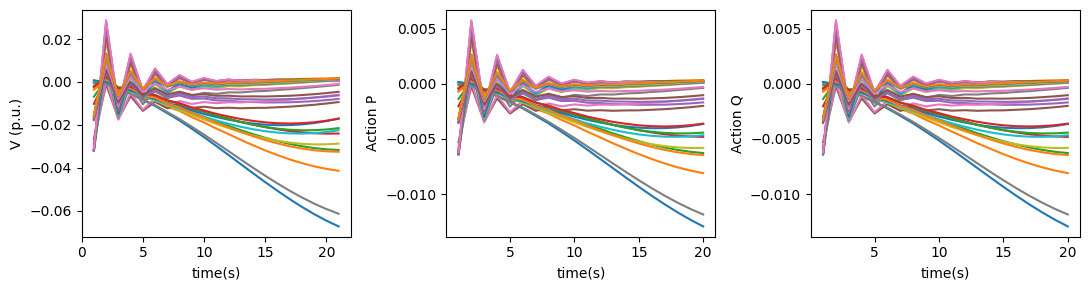

In [22]:
# Plot the trajectory to visulize the performance of control
Trajectory_Linear=[]
Q_init_ratio = 0.7
P_init_ratio = 0.7
delta_t = 1
Q = (Q_ref*np.random.uniform(1-Q_init_ratio ,1+Q_init_ratio ,(dim_action, 1))).T
P = (P_ref*np.random.uniform(1-P_init_ratio ,1+P_init_ratio ,(dim_action, 1))).T

s_concate=P@Matrix_R.T+Q@Matrix_X.T
init_state=s_concate.copy()
s=init_state.copy()
SimulationLength=20
# Record_u_Linear=[]
Record_up_Linear=[]
Record_uq_Linear=[]
Trajectory_Linear.append(s)
Record_Loss_Linear=[]
Loss_Linear=0
print('s',s)
record_v0 = np.diff(record_fault_trajectory[0,0,0,110:])
for i in range(SimulationLength):
    up=np.squeeze(Action_linear(s,linear_coffp))
    uq=np.squeeze(Action_linear(s,linear_coffq))
    next_s= s - uq@Matrix_X - up@Matrix_R + record_v0[i]
    s=next_s.copy()
    Trajectory_Linear.append(s.copy())
    Record_up_Linear.append(up.copy())
    Record_uq_Linear.append(uq.copy())

Trajectory_Linear=np.squeeze(np.asarray(Trajectory_Linear))
fig = plt.figure(figsize=(11,3), dpi=100)
TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=delta_t*TimeRecord
plt.subplot(1,3,1)
plt.plot(TimeRecord,Trajectory_Linear)
plt.xlabel('time(s)')
plt.ylabel('V (p.u.)')


TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=delta_t*TimeRecord
plt.subplot(1,3,2)
plt.plot(TimeRecord,Record_up_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action P')

plt.subplot(1,3,3)
plt.plot(TimeRecord,Record_uq_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action Q')
fig.tight_layout()


### With constant

s [[ 7.03953540e-05  5.89762867e-04  1.38178133e-03  2.29488448e-03
   2.60434651e-03  3.12706702e-03  5.24464580e-03  8.19661342e-03
   1.08960170e-02  1.11532953e-02  1.15402367e-02  1.40659232e-02
   1.48385401e-02  1.54888278e-02  1.63128213e-02  1.71193752e-02
   1.74193022e-02  4.18334596e-05 -4.62402321e-04 -7.07951677e-04
  -7.76216820e-04 -2.38384938e-04 -2.13305213e-03 -2.22017521e-03
   2.51732379e-03  2.36944580e-03  5.15742348e-03  7.47578593e-03
   7.76844926e-03  7.45319707e-03  7.49093737e-03  7.55906230e-03]]


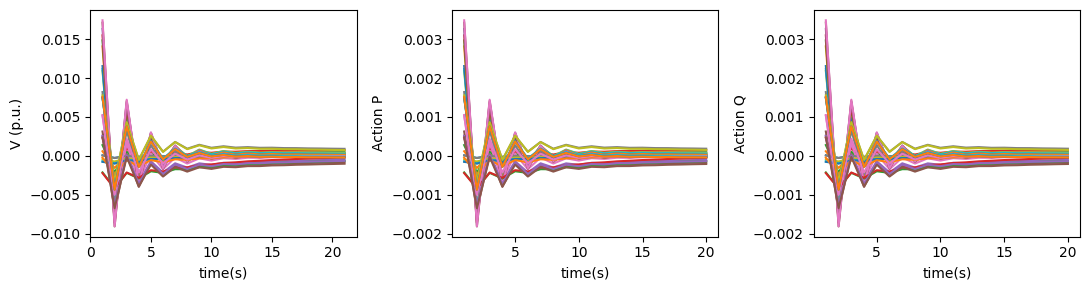

In [23]:
# Plot the trajectory to visulize the performance of control
Trajectory_Linear=[]
Q_init_ratio = 0.7
P_init_ratio = 0.7
delta_t = 1
Q = (Q_ref*np.random.uniform(1-Q_init_ratio ,1+Q_init_ratio ,(dim_action, 1))).T
P = (P_ref*np.random.uniform(1-P_init_ratio ,1+P_init_ratio ,(dim_action, 1))).T

s_concate=P@Matrix_R.T+Q@Matrix_X.T
init_state=s_concate.copy()
s=init_state.copy()
SimulationLength=20
# Record_u_Linear=[]
Record_up_Linear=[]
Record_uq_Linear=[]
Trajectory_Linear.append(s)
Record_Loss_Linear=[]
Loss_Linear=0
print('s',s)
record_v0 =0* np.diff(record_fault_trajectory[0,0,0,110:])
for i in range(SimulationLength):
    up=np.squeeze(Action_linear(s,linear_coffp))
    uq=np.squeeze(Action_linear(s,linear_coffq))
    next_s= s - uq@Matrix_X - up@Matrix_R + record_v0[i]
    s=next_s.copy()
    Trajectory_Linear.append(s.copy())
    Record_up_Linear.append(up.copy())
    Record_uq_Linear.append(uq.copy())

Trajectory_Linear=np.squeeze(np.asarray(Trajectory_Linear))
fig = plt.figure(figsize=(11,3), dpi=100)
TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=delta_t*TimeRecord
plt.subplot(1,3,1)
plt.plot(TimeRecord,Trajectory_Linear)
plt.xlabel('time(s)')
plt.ylabel('V (p.u.)')


TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=delta_t*TimeRecord
plt.subplot(1,3,2)
plt.plot(TimeRecord,Record_up_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action P')

plt.subplot(1,3,3)
plt.plot(TimeRecord,Record_uq_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action Q')
fig.tight_layout()


# Training

In [24]:
class RNNModel(tf.keras.Model):
    def __init__(self, cell):
        super().__init__()
        self.rnn = tf.keras.layers.RNN(cell, return_sequences=True, stateful=True)

    def call(self, inputs, initial_state=None):
        return self.rnn(inputs, initial_state=initial_state)

In [25]:
# RNN Cell to integrate state transition dynamics
class MinimalRNNCellLinear0(keras.layers.Layer):

    def __init__(self, units,action_units,internal_units,env,batchsize,K_boundq, K_boundp,**kwargs):
        self.units = units
        self.action_units = action_units
        self.state_size = units
        self.internal_units = internal_units
        self.batchsize=batchsize
        self.Matrix_X=tf.constant(env.Matrix_X,dtype=tf.float32)
        self.Matrix_R=tf.constant(env.Matrix_R,dtype=tf.float32)
        self.inv_Matrix_X = tf.constant(env.inv_Matrix_X,dtype=tf.float32)
        self.lambda_max = tf.constant(env.lambda_max,dtype=tf.float32)
        self.max_action=tf.constant(env.max_action,dtype=tf.float32)
        self.bound_slopq = tf.constant(K_boundq.reshape((1,-1)),dtype=tf.float32)
        self.bound_slopp = tf.constant(K_boundp.reshape((1,-1)),dtype=tf.float32)
        self.norm_q=1
        super(MinimalRNNCellLinear0, self).__init__(**kwargs)

    def build(self, input_shape):
        self.linear_Kp= self.add_weight(
            shape=(1,self.action_units),
            initializer=tf.keras.initializers.RandomUniform(minval=0.1, maxval=0.5),
            trainable=True,
            constraint=tf.keras.constraints.NonNeg(),
            name='linear_Kp')

        self.linear_Kq= self.add_weight(
            shape=(1,self.action_units),
            initializer=tf.keras.initializers.RandomUniform(minval=0.1, maxval=0.5),
            trainable=True,
            constraint=tf.keras.constraints.NonNeg(),
            name='linear_Kq')
        self.built = True

    def call(self, inputs_concate, states):
        # stacked ReLU structure to represent control network
        prev_state = states[0]
        prev_state_x = prev_state[:,0:self.action_units]
        prev_state_q =  prev_state[:,self.action_units:2*self.action_units]
        prev_state_p =  prev_state[:,2*self.action_units:3*self.action_units]
        inputs_p = inputs_concate[:,0:self.action_units]
        inputs_v0 = inputs_concate[:,self.action_units:self.action_units+1]


        linear_Kq_=tf.math.minimum(self.linear_Kq, self.bound_slopq )
        linear_Kp_=tf.math.minimum(self.linear_Kp, self.bound_slopp )
        action_q= K.sum(tf.linalg.diag(prev_state_x)*linear_Kq_,axis=2)
        action_p= K.sum(tf.linalg.diag(prev_state_x)*linear_Kp_,axis=2)
        # action=self.max_action-K.relu(self.max_action-action_nonconstrain)+K.relu(-self.max_action-action_nonconstrain)
        new_state_x=prev_state_x-K.dot(action_q, tf.transpose(self.Matrix_X))-K.dot(action_p, tf.transpose(self.Matrix_R))+ K.dot(inputs_p, tf.transpose(self.Matrix_R)) + K.dot(inputs_v0, tf.ones((1,self.action_units)))
        new_state_q = prev_state_q - action_q
        new_state_p = prev_state_p - action_p

        next_state =  tf.concat([new_state_x, new_state_q, new_state_p], axis = 1)


        return [new_state_x,action_q, action_p, new_state_q, new_state_p], [next_state]




In [26]:
# Gen_idx_Pnode = []
# for i in range(dim_action):
#     row_idx = np.random.randint(0, 13)
#     Gen_idx_Pnode.append(row_idx)

# Gen_idx_Pnode = np.asarray(Gen_idx_Pnode, dtype=np.uint32)

## Mapping time-varying load to different buses

f = open('/content/drive/MyDrive/Colab Notebooks/6. Adaptive Control/Caltech/voltage/data/Gen_idx_Pnode13.pkl', 'rb')
Gen_idx_Pnode= pickle.load(f)
f.close()

In [27]:
# This is the data for time-varying load
f = open('/content/drive/MyDrive/Colab Notebooks/6. Adaptive Control/Caltech/voltage/data/Caltech_data/record_pred1228n14.pckl', 'rb')

[list_true_test, list_result_test, list_norm_RegD]= pickle.load(f)
f.close()

In [28]:
magnitute_ratio = 0.3
list_true_test = magnitute_ratio * np.asarray(list_true_test,dtype=np.float32)
list_result_test = magnitute_ratio *np.asarray(list_result_test,dtype=np.float32)
list_true_test[3:6,:]=list_true_test[3:6,:]/10
list_result_test[3:6,:]=list_result_test[3:6,:]/10


In [30]:
episodes =1000 # total number of iterations to update weights
action_units=dim_action
units=action_units*3 #dimension of each state
internal_units=20 # demension of the neural network for control policy

T=100  #Total period considered
Batch_num=500 # number of batch in each episodes
learning_rate_initial=0.01
decay_stage = 100
decay_rate = 0.9

cellLinear0 = MinimalRNNCellLinear0(units,action_units,internal_units,env,Batch_num,K_bound_q,K_bound_p)
modelLinear0 = RNNModel(cellLinear0)

Loss_record=[]
Pe_rnn_record=[]
global_step = tf.Variable(0, trainable=False)
decayed_lr =tf.keras.optimizers.schedules.ExponentialDecay(
    learning_rate_initial, decay_stage, decay_rate, staircase=True)
optimizer=tf.keras.optimizers.Adam(learning_rate=decayed_lr)

Length_pred_dataset = np.array(list_true_test).shape[1]-100
column1_idx = np.arange(0,dim_action)
PrintUpdate = 1
for i in range(0,episodes):
    initial_state_q = (1- np.random.uniform(-Q_init_ratio,Q_init_ratio,(Batch_num,action_units)))*(Q_ref.T)
    initial_state_p = (1- np.random.uniform(-P_init_ratio,P_init_ratio,(Batch_num,action_units)))*(P_ref.T)
    initial_state=initial_state_p@Matrix_R.T+initial_state_q@Matrix_X.T

    Input_config = np.zeros((Batch_num,T,dim_action+1))
    for j in range(Batch_num):
       #### time varying p
       t_init_Pm = np.random.randint(0, Length_pred_dataset-T-1)
       Input_config[j,:,:dim_action]=np.transpose(list_true_test[Gen_idx_Pnode,t_init_Pm:t_init_Pm+T])
       ###### v0
       rand_fault_idx = np.random.randint(0,np.shape(record_fault_trajectory)[0])
       rand_time_idx = np.random.randint(100,150)
       rand_bus_idx = np.random.randint(0,np.shape(record_fault_trajectory)[2])
       Input_config[j,:,dim_action] = record_fault_trajectory[rand_fault_idx,0,rand_bus_idx,rand_time_idx:rand_time_idx+T]


    with tf.GradientTape(persistent=True) as tape:
        [voltage,action_q,action_p, record_q, record_p]=modelLinear0(Input_config, np.hstack((initial_state, initial_state_q, initial_state_p)))
        loss_voltage=K.sum(K.sum(K.abs(voltage)))/Batch_num/T/dim_action
        loss_action=0.01*(env.Penalty_action*K.sum(abs(record_q)))/Batch_num/T/dim_action + 0.01*(env.Penalty_action*K.sum(abs(record_p)))/Batch_num/T/dim_action
        loss=loss_voltage+loss_action
    grads = tape.gradient(loss, modelLinear0.variables)
    optimizer.apply_gradients(zip(grads, modelLinear0.variables))
    Loss_record.append(loss)



    if i % (PrintUpdate) == 0:
        print('episode',i, 'Loss',loss)
        print('         Loss_Voltage',loss_voltage, '  loss_action', loss_action)



episode 0 Loss tf.Tensor(3.4298282, shape=(), dtype=float32)
         Loss_Voltage tf.Tensor(3.3484762, shape=(), dtype=float32)   loss_action tf.Tensor(0.081351936, shape=(), dtype=float32)
episode 1 Loss tf.Tensor(3.3885493, shape=(), dtype=float32)
         Loss_Voltage tf.Tensor(3.305728, shape=(), dtype=float32)   loss_action tf.Tensor(0.08282137, shape=(), dtype=float32)
episode 2 Loss tf.Tensor(3.3412805, shape=(), dtype=float32)
         Loss_Voltage tf.Tensor(3.2571018, shape=(), dtype=float32)   loss_action tf.Tensor(0.08417867, shape=(), dtype=float32)
episode 3 Loss tf.Tensor(3.2697322, shape=(), dtype=float32)
         Loss_Voltage tf.Tensor(3.1850863, shape=(), dtype=float32)   loss_action tf.Tensor(0.08464597, shape=(), dtype=float32)
episode 4 Loss tf.Tensor(3.229125, shape=(), dtype=float32)
         Loss_Voltage tf.Tensor(3.143126, shape=(), dtype=float32)   loss_action tf.Tensor(0.08599894, shape=(), dtype=float32)
episode 5 Loss tf.Tensor(3.1692004, shape=(), dtype=

Text(0, 0.5, 'Loss')

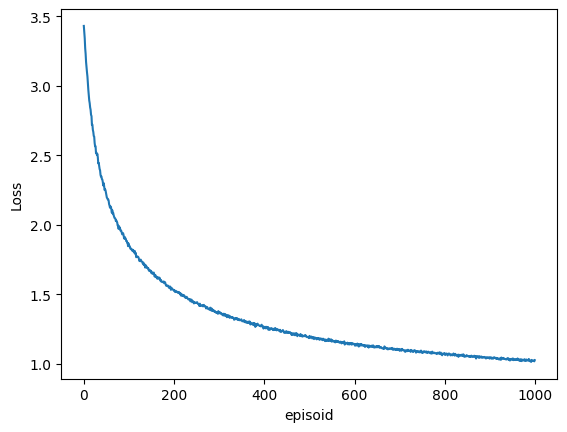

In [31]:
plt.plot(Loss_record)
plt.xlabel('episoid')
plt.ylabel('Loss')
# plt.title('Non-Discounted Loss without penalty')

In [32]:
modelLinear0.save_weights('/content/drive/MyDrive/Colab Notebooks/250805 data center/data/weights_K_250808.weights.h5')


# Simulation and Comparisons

## With trained controller

s [[0.00048409 0.00355356 0.00605264 0.00867938 0.01762234 0.02368456
  0.02518028 0.02882766 0.03212416 0.03232327 0.03280495 0.03288704
  0.03333027 0.03361467 0.03388964 0.03375502 0.03378487 0.00049412
  0.0003181  0.0002765  0.00016821 0.00344125 0.0025216  0.00153792
  0.01775618 0.01793355 0.01649448 0.01545926 0.0151206  0.01672251
  0.01712305 0.01708126]]


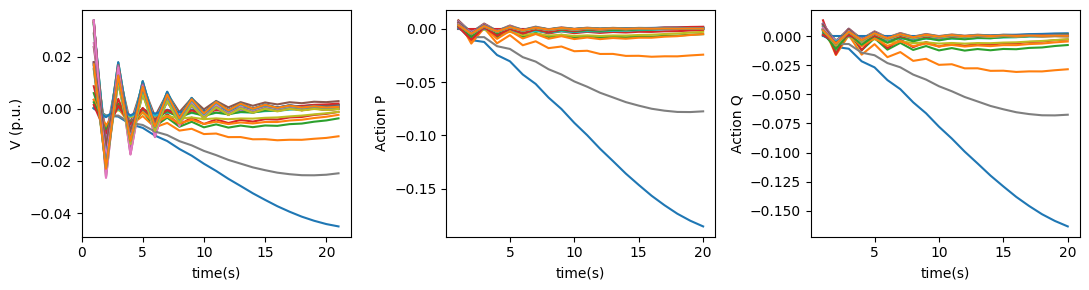

In [62]:
# Plot the trajectory to visulize the performance of control
Trajectory_Linear=[]
linear_coffp = tf.math.minimum(modelLinear0.variables[0], K_bound_p)
linear_coffq = tf.math.minimum(modelLinear0.variables[1], K_bound_q)

Q_init_ratio = 0.6
P_init_ratio = 0.6
delta_t = 1
Q = (Q_ref*np.random.uniform(1-Q_init_ratio ,1+Q_init_ratio ,(dim_action, 1))).T
P = (P_ref*np.random.uniform(1-P_init_ratio ,1+P_init_ratio ,(dim_action, 1))).T

s_concate=P@Matrix_R.T+Q@Matrix_X.T
init_state=s_concate.copy()
s=init_state.copy()
SimulationLength=20
# Record_u_Linear=[]
Record_up_Linear=[]
Record_uq_Linear=[]
Trajectory_Linear.append(s)
Record_Loss_Linear=[]
Loss_Linear=0
print('s',s)
record_v0 = np.diff(record_fault_trajectory[0,0,0,110:])
for i in range(SimulationLength):
    up=np.squeeze(Action_linear(s,linear_coffp))
    uq=np.squeeze(Action_linear(s,linear_coffq))
    next_s= s - uq@Matrix_X - up@Matrix_R + record_v0[i]
    s=next_s.copy()
    Trajectory_Linear.append(s.copy())
    Record_up_Linear.append(up.copy())
    Record_uq_Linear.append(uq.copy())

Trajectory_Linear=np.squeeze(np.asarray(Trajectory_Linear))
fig = plt.figure(figsize=(11,3), dpi=100)
TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=delta_t*TimeRecord
plt.subplot(1,3,1)
plt.plot(TimeRecord,Trajectory_Linear)
plt.xlabel('time(s)')
plt.ylabel('V (p.u.)')


TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=delta_t*TimeRecord
plt.subplot(1,3,2)
plt.plot(TimeRecord,Record_up_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action P')

plt.subplot(1,3,3)
plt.plot(TimeRecord,Record_uq_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action Q')
fig.tight_layout()


Text(0, 0.5, 'V0 (p.u.)')

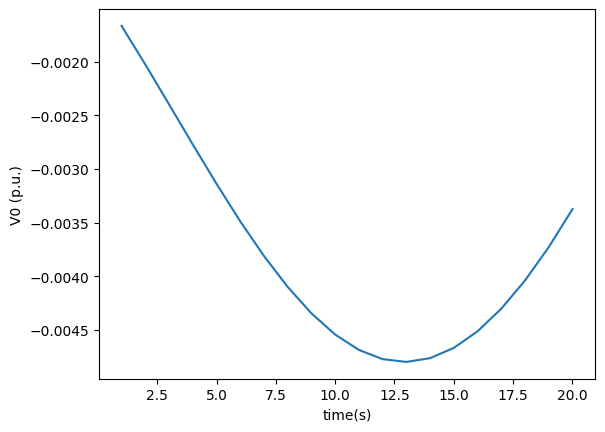

In [51]:
plt.plot(TimeRecord,record_v0[:SimulationLength])
plt.xlabel('time(s)')
plt.ylabel('V0 (p.u.)')

## without control

s [[0.00048409 0.00355356 0.00605264 0.00867938 0.01762234 0.02368456
  0.02518028 0.02882766 0.03212416 0.03232327 0.03280495 0.03288704
  0.03333027 0.03361467 0.03388964 0.03375502 0.03378487 0.00049412
  0.0003181  0.0002765  0.00016821 0.00344125 0.0025216  0.00153792
  0.01775618 0.01793355 0.01649448 0.01545926 0.0151206  0.01672251
  0.01712305 0.01708126]]


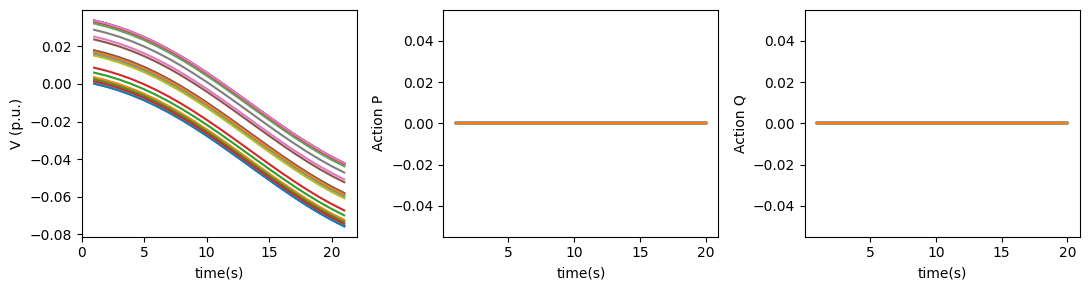

In [63]:
# Plot the trajectory to visulize the performance of control
Trajectory_Linear=[]
linear_coffp = tf.math.minimum(modelLinear0.variables[0], K_bound_p)*0
linear_coffq = tf.math.minimum(modelLinear0.variables[1], K_bound_q)*0


init_state=s_concate.copy()
s=init_state.copy()
SimulationLength=20
# Record_u_Linear=[]
Record_up_Linear=[]
Record_uq_Linear=[]
Trajectory_Linear.append(s)
Record_Loss_Linear=[]
Loss_Linear=0
print('s',s)
record_v0 = np.diff(record_fault_trajectory[0,0,0,110:])
for i in range(SimulationLength):
    up=np.squeeze(Action_linear(s,linear_coffp))
    uq=np.squeeze(Action_linear(s,linear_coffq))
    next_s= s - uq@Matrix_X - up@Matrix_R + record_v0[i]
    s=next_s.copy()
    Trajectory_Linear.append(s.copy())
    Record_up_Linear.append(up.copy())
    Record_uq_Linear.append(uq.copy())

Trajectory_Linear=np.squeeze(np.asarray(Trajectory_Linear))
fig = plt.figure(figsize=(11,3), dpi=100)
TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=delta_t*TimeRecord
plt.subplot(1,3,1)
plt.plot(TimeRecord,Trajectory_Linear)
plt.xlabel('time(s)')
plt.ylabel('V (p.u.)')


TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=delta_t*TimeRecord
plt.subplot(1,3,2)
plt.plot(TimeRecord,Record_up_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action P')

plt.subplot(1,3,3)
plt.plot(TimeRecord,Record_uq_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action Q')
fig.tight_layout()
